In [1396]:
import numpy as np
import matplotlib.pyplot as plt

In [1397]:
# Mean-reverting jump diffusion model

def simulate_short_rate(
    r0: float,
    long_term_mean: float,
    mean_reversion_speed: float,
    daily_volatility: float,
    jump_intensity_per_year: float,
    jump_mean: float,
    jump_std: float,
    years: float = 1.0,
    days_per_year: int = 252,
    seed: int = None
) -> np.ndarray:
    """
    Simulates a short rate using a mean-reverting jump diffusion model.

    Parameters:
        r0 (float): Initial short rate.
        long_term_mean (float): Long-term mean reversion level.
        mean_reversion_speed (float): Speed of mean reversion.
        daily_volatility (float): Daily volatility of the short rate.
        jump_intensity_per_year (float): Expected number of jumps per year.
        jump_mean (float): Mean size of jumps (annualized).
        jump_std (float): Standard deviation of jump sizes.
        years (float): Number of years to simulate.
        days_per_year (int): Trading days per year (default 252).
        seed (int): Random seed.

    Returns:
        np.ndarray: Array of simulated daily short rates.
    """
    
    if seed is not None:
        np.random.seed(seed)

    total_days = int(years * days_per_year)
    dt = 1 / days_per_year
    rates = np.zeros(total_days + 1)
    rates[0] = r0

    # Daily jump probability
    jump_prob = jump_intensity_per_year * dt

    for t in range(1, total_days + 1):
        # Mean-reversion drift
        drift = mean_reversion_speed * (long_term_mean - rates[t - 1]) * dt

        # Diffusion component
        diffusion = daily_volatility * np.sqrt(dt) * np.random.normal()

        # Jump component
        jump = 0
        if np.random.uniform() < jump_prob:
            jump = np.random.normal(jump_mean, jump_std)

        # Update rate
        rates[t] = rates[t - 1] + drift + diffusion + jump

    return rates

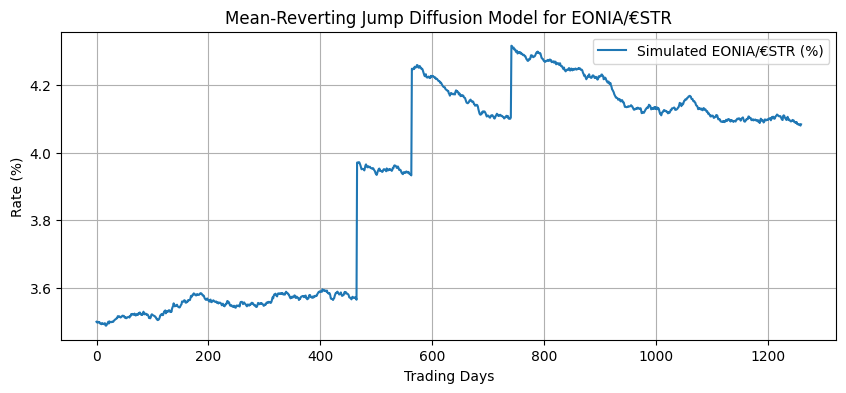

In [1398]:
if __name__ == "__main__":
    simulated_rates = simulate_short_rate(
        r0=0.035,                     # Starting rate 3.5%
        long_term_mean=0.035,         # Mean reversion to 3.5%
        mean_reversion_speed=0.2,     # Quick mean reversion
        daily_volatility=0.0005,      # Small daily volatility
        jump_intensity_per_year=1.5,  # On average, 1-2 jumps per year
        jump_mean=0.0025,             # Average jump of 25 bps
        jump_std=0.001,               # Std dev of jump size 10 bps
        years=5,                      # One year
        #seed=42
    )

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(simulated_rates * 100, label="Simulated EONIA/€STR (%)")
    plt.xlabel("Trading Days")
    plt.ylabel("Rate (%)")
    plt.title("Mean-Reverting Jump Diffusion Model for EONIA/€STR")
    plt.grid(True)
    plt.legend()
    plt.show()

Problem: there is reversion between rate changes, dont want that

In [1399]:
def simulate_ecb_rate(
    initial_rate: float,
    jump_intensity_per_year: float,
    jump_sizes: list,
    years: float,
    days_per_year: int,
    min_days_between_jumps: int = 30,
    seed: int = None
) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)

    total_days = int(years * days_per_year)
    dt = 1 / days_per_year
    rates = np.full(total_days + 1, initial_rate)

    jump_prob = jump_intensity_per_year * dt
    days_since_last_jump = min_days_between_jumps

    for t in range(1, total_days + 1):
        if days_since_last_jump >= min_days_between_jumps and np.random.uniform() < jump_prob:
            jump = np.random.choice(jump_sizes)
            rates[t:] += jump
            days_since_last_jump = 0
        else:
            days_since_last_jump += 1

    return rates

# Overnight rate (mean-reverting diffusion toward ECB rate)
def simulate_overnight_rate(
    initial_rate: float,
    ecb_rate: np.ndarray,
    mean_reversion_speed: float,
    daily_volatility: float,
    days_per_year: int,
    seed: int = None
) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed + 1)  # Different seed from ECB simulation

    total_days = len(ecb_rate) - 1
    dt = 1 / days_per_year
    rates = np.zeros(total_days + 1)
    rates[0] = initial_rate

    for t in range(1, total_days + 1):
        if ecb_rate[t] != ecb_rate[t - 1]:
            # Immediate adjustment to new ECB rate
            rates[t] = ecb_rate[t] + np.random.normal(0, daily_volatility * np.sqrt(dt))
        else:
            drift = mean_reversion_speed * (ecb_rate[t] - rates[t - 1]) * dt
            diffusion = daily_volatility * np.sqrt(dt) * np.random.normal()
            rates[t] = rates[t - 1] + drift + diffusion

    return rates

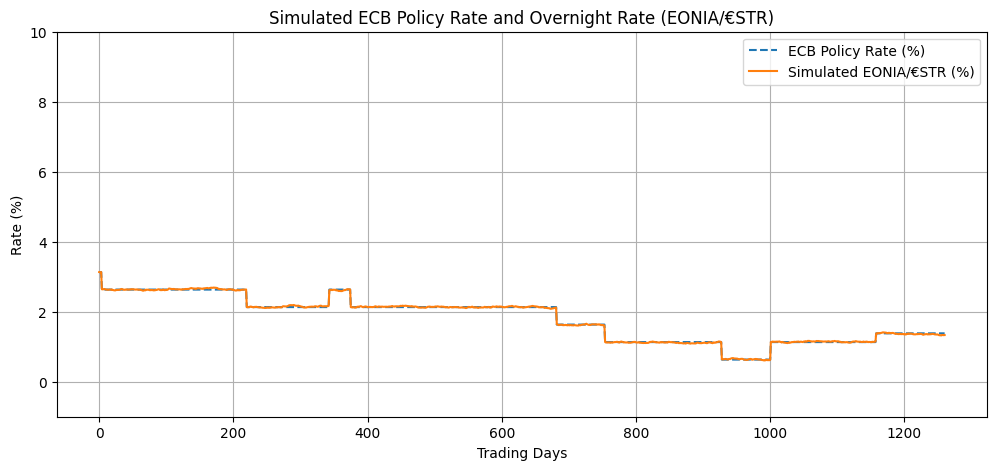

In [1400]:
if __name__ == "__main__":
    years = 5
    days_per_year = 252

    rate = np.random.uniform(0.01, 0.05)
    ecb_rate = simulate_ecb_rate(
        #initial_rate=0.035,
        initial_rate=rate,
        jump_intensity_per_year=2,
        jump_sizes=[0.0025, -0.0025, 0.005, -0.005],
        #long_term_mean=0.03,
        #mean_reversion_speed=0.1,
        years=years,
        min_days_between_jumps=30,
        days_per_year=days_per_year,
        #seed=42
    )

    overnight_rate = simulate_overnight_rate(
        #initial_rate=0.035,
        initial_rate=rate,
        ecb_rate=ecb_rate,
        mean_reversion_speed=15,
        daily_volatility=0.001,
        days_per_year=days_per_year,
        #seed=42
    )

    plt.figure(figsize=(12, 5))
    plt.plot(ecb_rate * 100, label="ECB Policy Rate (%)", linestyle='--')
    plt.plot(overnight_rate * 100, label="Simulated EONIA/€STR (%)")
    plt.xlabel("Trading Days")
    plt.ylabel("Rate (%)")
    plt.title("Simulated ECB Policy Rate and Overnight Rate (EONIA/€STR)")
    plt.grid(True)
    plt.ylim(-1, 10)
    plt.legend()
    plt.show()

ToDo: Make long there be some mean reversion in the rate decisions itself

In [1401]:
def simulate_ecb_rate(
    initial_rate: float,
    jump_intensity_per_year: float,
    base_jump_size: float,
    long_term_mean: float,
    mean_reversion_strength: float,
    years: float,
    days_per_year: int,
    min_days_between_jumps: int = 45,
    seed: int = None
) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)

    total_days = int(years * days_per_year)
    dt = 1 / days_per_year
    rates = np.zeros(total_days + 1)
    rates[0] = initial_rate

    jump_prob = jump_intensity_per_year * dt
    days_since_last_jump = min_days_between_jumps

    for t in range(1, total_days + 1):
        rate = rates[t - 1]

        if days_since_last_jump >= min_days_between_jumps and np.random.uniform() < jump_prob:
            # Calculate deviation from long-term mean
            deviation = long_term_mean - rate

            # Generate a base jump direction with some randomness
            # This allows the rate to move away from mean more often
            jump_direction = np.random.choice([-1, 1], p=[0.5, 0.5])

            # Calculate mean reversion component - scaled by the parameter
            mean_reversion_component = mean_reversion_strength * deviation

            # Generate the jump - base size plus mean reversion influence
            # When mean_reversion_strength is low, the jump is dominated by the random component
            jump = jump_direction * base_jump_size + mean_reversion_component

            # Don't clip jumps to allow for more extreme movements
            # Instead, implement a safety check only for negative rates if desired
            new_rate = rate + jump

            # Optional: prevent extremely negative rates but allow them to go negative
            # Remove this if you want completely unbounded behavior
            if new_rate < -0.01:
                new_rate = -0.01

            rates[t] = new_rate
            days_since_last_jump = 0
        else:
            rates[t] = rate
            days_since_last_jump += 1

    return rates

# Overnight rate (mean-reverting diffusion toward ECB rate)
def simulate_overnight_rate(
    initial_rate: float,
    ecb_rate: np.ndarray,
    mean_reversion_speed: float,
    daily_volatility: float,
    days_per_year: int,
    seed: int = None
) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed + 1)  # Different seed from ECB simulation

    total_days = len(ecb_rate) - 1
    dt = 1 / days_per_year
    rates = np.zeros(total_days + 1)
    rates[0] = initial_rate

    for t in range(1, total_days + 1):
        if ecb_rate[t] != ecb_rate[t - 1]:
            # Immediate adjustment to new ECB rate
            rates[t] = ecb_rate[t] + \
                np.random.normal(0, daily_volatility * np.sqrt(dt))
        else:
            drift = mean_reversion_speed * (ecb_rate[t] - rates[t - 1]) * dt
            diffusion = daily_volatility * np.sqrt(dt) * np.random.normal()
            rates[t] = rates[t - 1] + drift + diffusion

    return rates

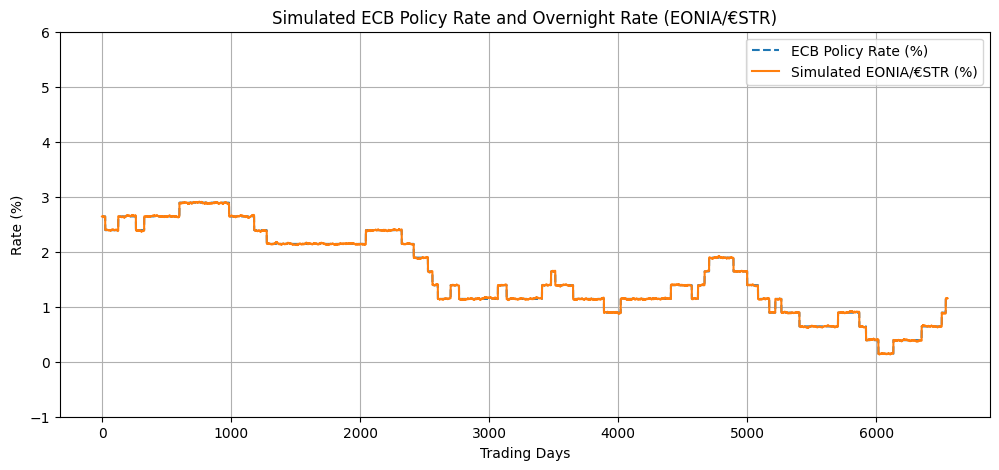

In [1402]:
if __name__ == "__main__":
    years = 26
    days_per_year = 252

    rate = np.random.uniform(0.01, 0.05)
    ecb_rate = simulate_ecb_rate(
        #initial_rate=0.035,
        initial_rate=rate,
        jump_intensity_per_year=2,
        base_jump_size=0.0025,
        long_term_mean=0.03,
        mean_reversion_strength=0.000001,
        years=years,
        days_per_year=days_per_year,
        min_days_between_jumps=30,
        #seed=42
    )

    overnight_rate = simulate_overnight_rate(
        #initial_rate=0.035,
        initial_rate=rate,
        ecb_rate=ecb_rate,
        mean_reversion_speed=15,
        daily_volatility=0.0005,
        days_per_year=days_per_year,
        #seed=42
    )

    plt.figure(figsize=(12, 5))
    plt.plot(ecb_rate * 100, label="ECB Policy Rate (%)", linestyle='--')
    plt.plot(overnight_rate * 100, label="Simulated EONIA/€STR (%)")
    plt.xlabel("Trading Days")
    plt.ylabel("Rate (%)")
    plt.title("Simulated ECB Policy Rate and Overnight Rate (EONIA/€STR)")
    plt.grid(True)
    plt.ylim(-1, 6)
    plt.legend()
    plt.show()

We are starting to get somewhere, but we need Trend Persistence (on average), i.e., often making several moves in the same direction

Trend Persistence Parameter: A new parameter (0-1) that controls how likely the rate is to continue moving in the same direction as previous jumps.

Trend Memory: The simulation now tracks: The current trend direction (up or down)
The strength of that trend (how many consecutive jumps in the same direction)

Self-Reinforcing Trends: As a trend continues, the jumps become slightly larger (via the trend_factor), creating the persistent upward/downward movements seen in real ECB data.

Mean Reversion with Trend Breaking: When a trend breaks, mean reversion has more influence, helping to eventually pull extreme rates back toward the long-term mean.

Probabilistic Direction Changes: Even during a trend, there's always a chance to reverse direction, controlled by the trend_persistence parameter.

In [1403]:
def simulate_ecb_rate(
    initial_rate: float,
    jump_intensity_per_year: float,
    base_jump_size: float,
    long_term_mean: float,
    mean_reversion_strength: float,
    # New parameter: 0-1 value, higher means stronger trend following
    trend_persistence: float,
    years: float,
    days_per_year: int,
    min_days_between_jumps: int = 45,
    seed: int = None
) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)

    total_days = int(years * days_per_year)
    dt = 1 / days_per_year
    rates = np.zeros(total_days + 1)
    rates[0] = initial_rate

    jump_prob = jump_intensity_per_year * dt
    days_since_last_jump = min_days_between_jumps

    # Track the current trend direction (1 = up, -1 = down, 0 = initial)
    current_trend = 0
    # Track how many consecutive jumps have followed the trend
    trend_strength = 0
    # Maximum trend strength (to prevent runaway trends)
    max_trend_strength = 5

    for t in range(1, total_days + 1):
        rate = rates[t - 1]

        if days_since_last_jump >= min_days_between_jumps and np.random.uniform() < jump_prob:
            # Calculate deviation from long-term mean
            deviation = long_term_mean - rate

            # Determine if we should follow the existing trend
            if current_trend != 0 and np.random.uniform() < trend_persistence:
                # Follow the existing trend
                jump_direction = current_trend
                # Increase trend strength (but cap it)
                trend_strength = min(trend_strength + 1, max_trend_strength)
            else:
                # Start a new trend or break the existing one
                # Mean reversion influence becomes stronger here
                mean_reversion_influence = 0.5 + 0.5 * mean_reversion_strength

                # Higher probability of moving toward the mean
                if deviation > 0:  # Below mean, should tend upward
                    p_up = 0.5 + mean_reversion_influence * 0.5
                    jump_direction = np.random.choice(
                        [-1, 1], p=[1-p_up, p_up])
                else:  # Above mean, should tend downward
                    p_down = 0.5 + mean_reversion_influence * 0.5
                    jump_direction = np.random.choice(
                        [-1, 1], p=[p_down, 1-p_down])

                # Set new trend and reset trend strength
                current_trend = jump_direction
                trend_strength = 1

            # Calculate mean reversion component - scaled by the parameter
            mean_reversion_component = mean_reversion_strength * deviation

            # Scale base jump size by trend strength for more persistent trends
            trend_factor = 1.0 + (trend_strength / 10.0)

            # Generate the jump - trend-adjusted base size plus mean reversion influence
            jump = jump_direction * base_jump_size * \
                trend_factor + mean_reversion_component

            # Optional: prevent extremely negative rates
            new_rate = rate + jump
            if new_rate < -0.01:
                new_rate = -0.01

            rates[t] = new_rate
            days_since_last_jump = 0
        else:
            rates[t] = rate
            days_since_last_jump += 1

    return rates

# Overnight rate (mean-reverting diffusion toward ECB rate)
def simulate_overnight_rate(
    initial_rate: float,
    ecb_rate: np.ndarray,
    mean_reversion_speed: float,
    daily_volatility: float,
    days_per_year: int,
    seed: int = None
) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed + 1)  # Different seed from ECB simulation

    total_days = len(ecb_rate) - 1
    dt = 1 / days_per_year
    rates = np.zeros(total_days + 1)
    rates[0] = initial_rate

    for t in range(1, total_days + 1):
        if ecb_rate[t] != ecb_rate[t - 1]:
            # Immediate adjustment to new ECB rate
            rates[t] = ecb_rate[t] + \
                np.random.normal(0, daily_volatility * np.sqrt(dt))
        else:
            drift = mean_reversion_speed * (ecb_rate[t] - rates[t - 1]) * dt
            diffusion = daily_volatility * np.sqrt(dt) * np.random.normal()
            rates[t] = rates[t - 1] + drift + diffusion

    return rates

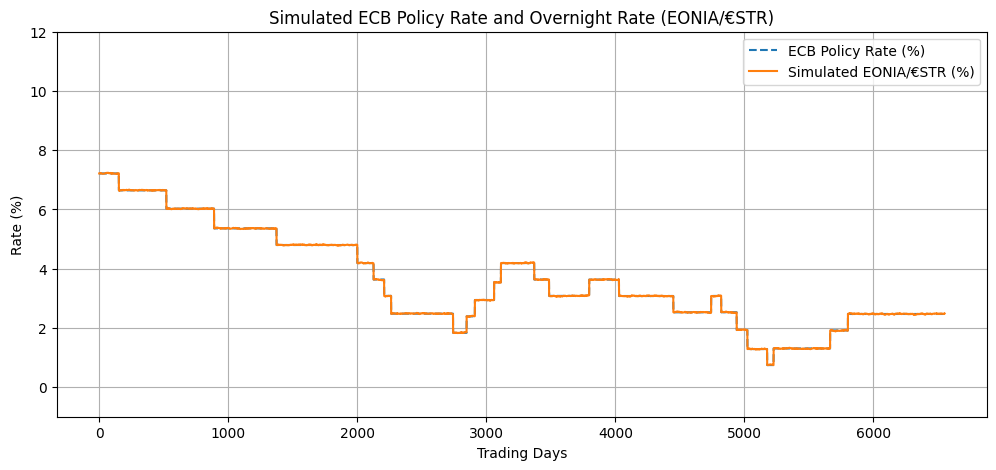

In [1404]:
if __name__ == "__main__":
    years = 26
    days_per_year = 252

    rate = np.random.uniform(0.0, 0.12)
    ecb_rate = simulate_ecb_rate(
        # initial_rate=0.035,
        initial_rate=rate,
        jump_intensity_per_year=1.5,
        base_jump_size=0.005,
        long_term_mean=0.03,
        mean_reversion_strength=0.005,
        years=years,
        days_per_year=days_per_year,
        min_days_between_jumps=45,
        trend_persistence=0.5,  
        # seed=42
    )

    overnight_rate = simulate_overnight_rate(
        # initial_rate=0.035,
        initial_rate=rate,
        ecb_rate=ecb_rate,
        mean_reversion_speed=15,
        daily_volatility=0.0005,
        days_per_year=days_per_year,
        # seed=42
    )

    plt.figure(figsize=(12, 5))
    plt.plot(ecb_rate * 100, label="ECB Policy Rate (%)", linestyle='--')
    plt.plot(overnight_rate * 100, label="Simulated EONIA/€STR (%)")
    plt.xlabel("Trading Days")
    plt.ylabel("Rate (%)")
    plt.title("Simulated ECB Policy Rate and Overnight Rate (EONIA/€STR)")
    plt.grid(True)
    plt.ylim(-1, 12)
    plt.legend()
    plt.show()

Incorporating the effect of staying at plateaus where the ECB rate remains stable for extended periods after reaching local maxima or minima. This reflects the real-world monetary policy behavior where central banks tend to hold rates steady at extremes while they wait for their policy actions to fully impact the economy.

In [1405]:
def simulate_ecb_rate(
    initial_rate: float,
    jump_intensity_per_year: float,
    base_jump_size: float,
    long_term_mean: float,
    mean_reversion_strength: float,
    trend_persistence: float,  # 0-1 value, higher means stronger trend following
    # New parameter: likelihood of forming a plateau at extremes
    plateau_likelihood: float,
    # New parameter: controls how long plateaus tend to last
    plateau_duration_factor: float,
    years: float,
    days_per_year: int,
    min_days_between_jumps: int = 30,
    seed: int = None
) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)

    total_days = int(years * days_per_year)
    dt = 1 / days_per_year
    rates = np.zeros(total_days + 1)
    rates[0] = initial_rate

    jump_prob = jump_intensity_per_year * dt
    days_since_last_jump = min_days_between_jumps

    # Track the current trend direction (1 = up, -1 = down, 0 = initial)
    current_trend = 0
    # Track how many consecutive jumps have followed the trend
    trend_strength = 0
    # Maximum trend strength (to prevent runaway trends)
    max_trend_strength = 5

    # Track plateau state
    in_plateau = False
    plateau_remaining_duration = 0

    # Historical tracking to detect peaks and troughs
    rate_history = [initial_rate]

    for t in range(1, total_days + 1):
        rate = rates[t - 1]

        # Determine if we're at a decision point for a potential jump
        make_jump_decision = days_since_last_jump >= min_days_between_jumps and np.random.uniform() < jump_prob

        if make_jump_decision:
            # If we're in a plateau, check if we should stay there
            if in_plateau:
                if plateau_remaining_duration > 0:
                    # Stay in plateau
                    plateau_remaining_duration -= 1
                    rates[t] = rate
                    days_since_last_jump = 0  # Reset counter as we made a "decision" to stay
                    continue
                else:
                    # Exit plateau state
                    in_plateau = False

            # Not in plateau or exiting plateau
            # Check if we might be at a local extremum (potential plateau point)
            is_potential_peak = False
            is_potential_trough = False

            # Simple detection of peaks/troughs based on trend direction change
            if len(rate_history) >= 3:
                # Use trend strength as a clue - strong trends often lead to plateaus
                if trend_strength >= 3:
                    # For uptrend reaching potential peak
                    if current_trend > 0:
                        is_potential_peak = True
                    # For downtrend reaching potential trough
                    elif current_trend < 0:
                        is_potential_trough = True

            # Calculate deviation from long-term mean
            deviation = long_term_mean - rate

            # Decide whether to enter plateau state
            if (is_potential_peak or is_potential_trough) and np.random.uniform() < plateau_likelihood:
                # Enter plateau state
                in_plateau = True
                # Stronger trends and further deviations from mean result in longer plateaus
                # Also, troughs tend to last longer than peaks
                base_duration = int(trend_strength * plateau_duration_factor)
                if is_potential_trough:
                    # Troughs (low rates) often last longer
                    plateau_remaining_duration = base_duration * 2
                else:
                    plateau_remaining_duration = base_duration

                # Stay at current rate
                rates[t] = rate
                days_since_last_jump = 0
                continue

            # Standard rate change logic (when not entering a plateau)
            # Determine if we should follow the existing trend
            if current_trend != 0 and np.random.uniform() < trend_persistence:
                # Follow the existing trend
                jump_direction = current_trend
                # Increase trend strength (but cap it)
                trend_strength = min(trend_strength + 1, max_trend_strength)
            else:
                # Start a new trend or break the existing one
                # Mean reversion influence becomes stronger here
                mean_reversion_influence = 0.5 + 0.5 * mean_reversion_strength

                # Higher probability of moving toward the mean
                if deviation > 0:  # Below mean, should tend upward
                    p_up = 0.5 + mean_reversion_influence * 0.5
                    jump_direction = np.random.choice(
                        [-1, 1], p=[1-p_up, p_up])
                else:  # Above mean, should tend downward
                    p_down = 0.5 + mean_reversion_influence * 0.5
                    jump_direction = np.random.choice(
                        [-1, 1], p=[p_down, 1-p_down])

                # Set new trend and reset trend strength
                current_trend = jump_direction
                trend_strength = 1

            # Calculate mean reversion component - scaled by the parameter
            mean_reversion_component = mean_reversion_strength * deviation

            # Scale base jump size by trend strength for more persistent trends
            trend_factor = 1.0 + (trend_strength / 10.0)

            # Generate the jump - trend-adjusted base size plus mean reversion influence
            jump = jump_direction * base_jump_size * \
                trend_factor + mean_reversion_component

            # Apply jump
            new_rate = rate + jump

            # Optional: prevent extremely negative rates
            if new_rate < -0.01:
                new_rate = -0.01

            rates[t] = new_rate
            rate_history.append(new_rate)
            days_since_last_jump = 0
        else:
            rates[t] = rate
            days_since_last_jump += 1

    return rates


# Overnight rate (mean-reverting diffusion toward ECB rate)
def simulate_overnight_rate(
    initial_rate: float,
    ecb_rate: np.ndarray,
    mean_reversion_speed: float,
    daily_volatility: float,
    days_per_year: int,
    seed: int = None
) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed + 1)  # Different seed from ECB simulation

    total_days = len(ecb_rate) - 1
    dt = 1 / days_per_year
    rates = np.zeros(total_days + 1)
    rates[0] = initial_rate

    for t in range(1, total_days + 1):
        if ecb_rate[t] != ecb_rate[t - 1]:
            # Immediate adjustment to new ECB rate
            rates[t] = ecb_rate[t] + \
                np.random.normal(0, daily_volatility * np.sqrt(dt))
        else:
            drift = mean_reversion_speed * (ecb_rate[t] - rates[t - 1]) * dt
            diffusion = daily_volatility * np.sqrt(dt) * np.random.normal()
            rates[t] = rates[t - 1] + drift + diffusion

    return rates

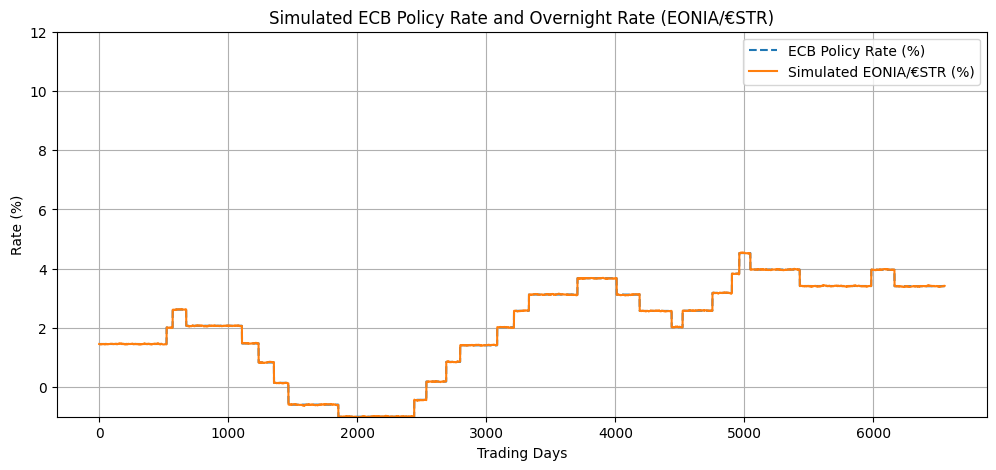

In [1421]:
if __name__ == "__main__":
    years = 26
    days_per_year = 252

    rate = np.random.uniform(0.0, 0.12)
    ecb_rate = simulate_ecb_rate(
        # initial_rate=0.035,
        initial_rate=rate,
        jump_intensity_per_year=1.5,
        base_jump_size=0.005,
        long_term_mean=0.03,
        mean_reversion_strength=0.005,
        years=years,
        days_per_year=days_per_year,
        min_days_between_jumps=45,
        trend_persistence=0.5,
        plateau_likelihood=0.05,
        plateau_duration_factor=3,
        # seed=42
    )

    overnight_rate = simulate_overnight_rate(
        # initial_rate=0.035,
        initial_rate=rate,
        ecb_rate=ecb_rate,
        mean_reversion_speed=15,
        daily_volatility=0.0005,
        days_per_year=days_per_year,
        # seed=42
    )

    plt.figure(figsize=(12, 5))
    plt.plot(ecb_rate * 100, label="ECB Policy Rate (%)", linestyle='--')
    plt.plot(overnight_rate * 100, label="Simulated EONIA/€STR (%)")
    plt.xlabel("Trading Days")
    plt.ylabel("Rate (%)")
    plt.title("Simulated ECB Policy Rate and Overnight Rate (EONIA/€STR)")
    plt.grid(True)
    plt.ylim(-1, 12)
    plt.legend()
    plt.show()

Possible improvements: 
- Time-varying parameters (volatility and jump intensity to change with market conditions, regime-switching)
- Corridor system modelling (ECB uses a corridor system where overnight rates stay within bounds of the policy rate)